In [ ]:
#PDL testing. NB: Artifacts at boundary!

# x = range(-1000, 1000, length = 10000)
# println("HI")
# h = x[2] - x[1]
# α = 1.5
# u = (x) -> (1+x^2)^(-(1-α)/2)
# fracLap_u = (x) -> 2^α * gamma((1+α)/2)/gamma((1-α)/2) * (1+x^2)^(-(1+α)/2)
# p2 = plot(x, fracLap_u.(x), xlim=(-10,10), label="fracLap_u")

# PDL = fft_create_PDL_matrix(10000, α, h, 100) 
# PDL_u = PDL*u.(x)

# scatter!(p2, x, PDL_u, xlim=(-10,10), label="PDL_u")

In [1]:
using DelimitedFiles;
using JSON
using DelimitedFiles;
using Plots, LaTeXStrings;
using Printf


function read_run_results(run_number)
    U_list = []
    M_list = []
    run="new_MFG_convergence_rate_runs/run"*string(run_number)
    params = JSON.parsefile(run*"_params.json")
    Δt = params["Δt"]
    for h in params["h_list"]
        push!(U_list, readdlm(run*"_U_mat_conv_h$(h)_deltat$(Δt).csv", ','))
        push!(M_list, readdlm(run*"_M_mat_conv_h$(h)_deltat$(Δt).csv", ','))
    end
    return params, U_list, M_list
end

params, U_list, M_list = read_run_results(1)
println("params: ", params)
println("size(U_list[1]): ", size(U_list[1]))

#PLOT RESULTS

function plot_results(run_number, save_figures=false)
    params, U_list, M_list = read_run_results(run_number)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    println("Plot results for run number: ", run_number) 
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list)
        println("----")
        println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        println("x_vec: ", x_vec)
        println("N_h: ", N_h)
        println("t_vec: ", t_vec)
        println("N_T: ", N_T)

        plot_U_mat = U_list[i];
        plot_M_mat = M_list[i];

        zticks1 = 5:5:20
        p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
        color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
        zticks2 = 0.5:0.5:4
        p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
        color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)",  ylim=(0, 1))

        # Save plots as PDF with h in the filename
        if save_figures
            savefig(p1, joinpath("figures",run*"_plot_new_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p2, joinpath("figures",run*"_plot_new_U_h$(h)_deltat$(Δt).pdf"))
        end 
        p = plot(p1, p2, layout=2, size=(600, 300), title="h="*string(h), titlefontsize=10)
        println("Display:") 
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

params: Dict{String, Any}("T" => 1, "δ" => 0.4, "x_l" => -1, "h_list" => Any[0.015625, 0.0078125], "x_r" => 2, "ν" => 0.0081, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.01, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list[1]): (192, 100)


plot_results (generic function with 2 methods)

Plot results for run number: 4
!!
parameters: Dict{String, Any}("T" => 1, "δ" => 0.4, "x_l" => -1, "h_list" => Any[0.0078125, 0.00390625, 0.001953125], "x_r" => 2, "ν" => 0.0081, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.001, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list): (3,)
----
i: 1
x_vec: -1.0:0.0078125:1.9921875
N_h: 384
t_vec: 0.0:0.001:0.999
N_T: 1000
Display:
!!!!!!!!!
----
i: 2
x_vec: -1.0:0.00390625:1.99609375
N_h: 768
t_vec: 0.0:0.001:0.999
N_T: 1000
Display:
!!!!!!!!!
----
i: 3
x_vec: -1.0:0.001953125:1.998046875
N_h: 1536
t_vec: 0.0:0.001:0.999
N_T: 1000
Display:
!!!!!!!!!


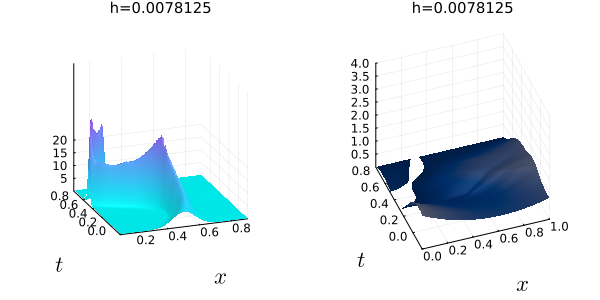

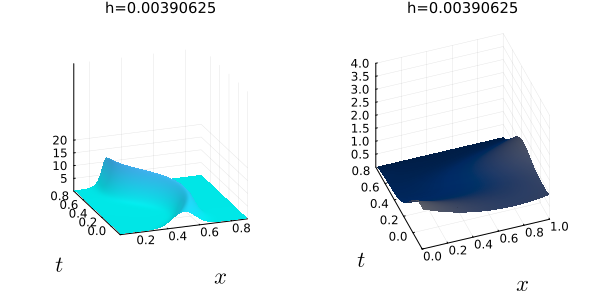

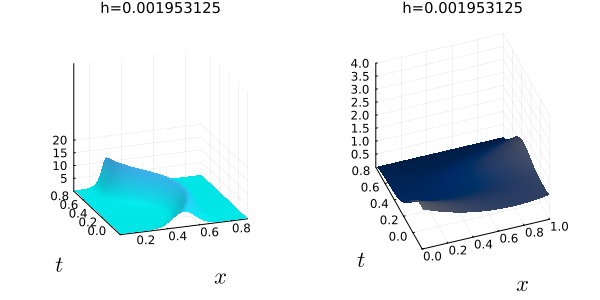

In [2]:
plot_results(4)

In [3]:

#PLOT RESULTS AT FINAL TIME

function plot_final_time_results(run_number, save_figures=false)
    params, U_list, M_list = read_run_results(run_number)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    println("FINAL TIME PLOTS")
    println("Plot results for run number: ", run_number) 
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list)
        println("----")
        println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        println("x_vec: ", x_vec)
        println("N_h: ", N_h)
        println("t_vec: ", t_vec)
        println("N_T: ", N_T)

        ###################################
        time_index = div(length(t_vec),1)
        println("time_index: ", time_index)

        plot_U_mat_final = U_list[i][:,1];
        plot_M_mat_final = M_list[i][:,time_index];
        plot_U_mat_first = U_list[i][:,time_index];
        plot_M_mat_first = M_list[i][:,1];

        p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[time_index]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[1]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        p3 = plot(x_vec, plot_M_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[1]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        
        p4 = plot(x_vec, plot_U_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[time_index]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        if save_figures
            savefig(p1, joinpath("figures",run*"_final_time_plot_final_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p2, joinpath("figures",run*"_final_time_plot_final_U_h$(h)_deltat$(Δt).pdf"))
            savefig(p3, joinpath("figures",run*"_final_time_plot_first_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p4, joinpath("figures",run*"_final_time_plot_first_U_h$(h)_deltat$(Δt).pdf"))
        end
        p = plot(p1, p2, p3, p4, layout=4, size=(600, 600), titlefontsize=10)
        println("Display:")
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

plot_final_time_results (generic function with 2 methods)

FINAL TIME PLOTS
Plot results for run number: 4
!!
parameters: Dict{String, Any}("T" => 1, "δ" => 0.4, "x_l" => -1, "h_list" => Any[0.0078125, 0.00390625, 0.001953125], "x_r" => 2, "ν" => 0.0081, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.001, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list): (3,)
----
i: 1
x_vec: -1.0:0.0078125:1.9921875
N_h: 384
t_vec: 0.0:0.001:0.999
N_T: 1000
time_index: 1000
Display:
!!!!!!!!!
----
i: 2
x_vec: -1.0:0.00390625:1.99609375
N_h: 768
t_vec: 0.0:0.001:0.999
N_T: 1000
time_index: 1000
Display:
!!!!!!!!!
----
i: 3
x_vec: -1.0:0.001953125:1.998046875
N_h: 1536
t_vec: 0.0:0.001:0.999
N_T: 1000
time_index: 1000
Display:
!!!!!!!!!


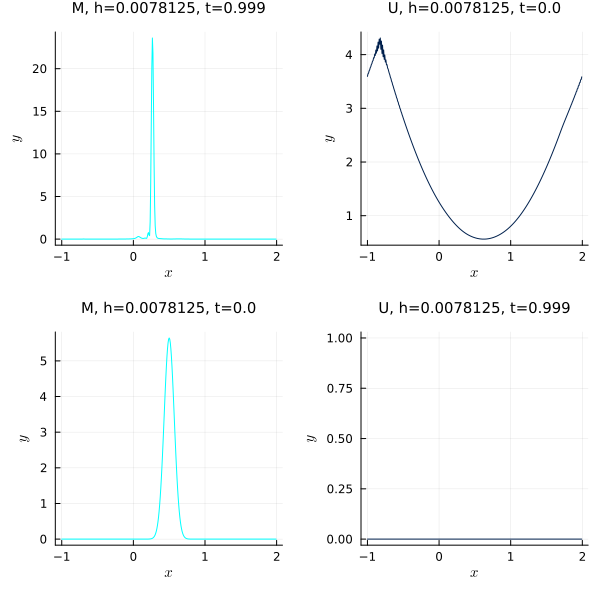

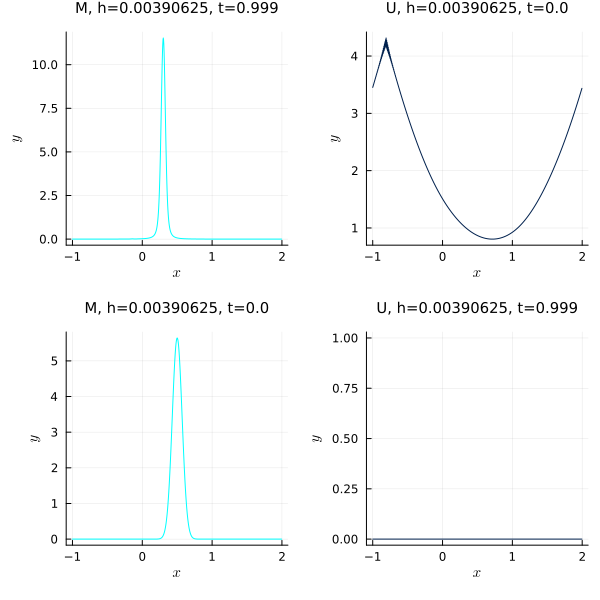

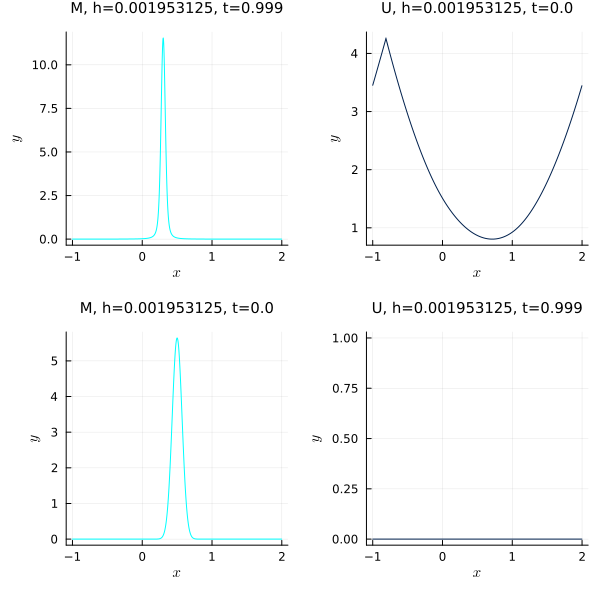

In [4]:
plot_final_time_results(4)